# Project Title: Turbidity and TDS Estimation Using Sentinel-2 Surface Reflectance Data for Siliguri, India
<!-- # Authors: Sohan Nag -->
# Date: Sepetember 2025
## Description: This notebook estimates water quality parameters (Turbidity and TDS) using Sentinel-2 data for Mahananda River, Siliguri, India.

### Overview:
This notebook demonstrates how to use Google Earth Engine (GEE) to analyze Sentinel-2 SR data for a specific study area in Siliguri, India. The analysis includes filtering the Sentinel-2 image collection by date, applying cloud masking, composing, calculating Turbidity and TDS, and visualizing the results on a map. The timeframe for this study is the Summer of 2023 till Winter of 2024. So, the time period is from 2023-03-01 to 2024-02-28.

The idea behind this timeframe is as follows:
- Pre-Monsoon 2023: March, April, May
- Monsoon 2023: June, July, August
- Post-Monsoon 2023: September, October, November
- Winter 2024: December, January, February

Thus, we can analyze the seasonal variations in water quality parameters and understand the impact of monsoon on the river water quality even for a short duration of one year on a short section of the river.

### Study Area:
The study area is a section of the river Mahananda, located in Siliguri, India. The area is defined by a FeatureCollection stored in a GEE asset.

### Methodology:
1. **Import Libraries**: Import necessary libraries including `ee` for Earth Engine and `geemap` for mapping.
2. **Initialize Earth Engine**: Authenticate and initialize the Earth Engine API.
3. **Load Study Area**: Load the study area from a GEE asset.
4. **Filter Sentinel-2 Image Collection**: Filter the Sentinel-2 SR image collection by date and bounds.
5. **Cloud Masking**: Apply a cloud masking function to remove clouds and cloud shadows from the images.
6. **Composite Images**: Create composite images by averaging the filtered images.
7. **Calculate NDWI**: Calculate the Normalized Difference Water Index (NDWI) from the Sentinel-2 bands.
    - This index helps in identifying water bodies and mask out the water bodies through NDWI thresholding.
8. **Calculate Turbidity and TDS**: Use established empirical formulas to calculate Turbidity and TDS from the Sentinel-2 bands.
9. **Visualization**: Visualize the results using geemap.
    a. Display the study area.
    b. Display the Sentinel-2 RGB composite.
    c. Display the Turbidity and TDS maps as masked out water bodies from the NDWI thresholding.
    d. Add legends for Turbidity and TDS maps.


In [33]:
# Importing Libraries
import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Earth Engine Authentication and Initialization
try:
    ee.Authenticate()
    ee.Initialize(project='ee-sohanlearning')
except Exception as e:
    print("Successfully authenticated and initialized Earth Engine.")
    print("Error during authentication or initialization:", e)

In [35]:
# Initializing the Map
Map = geemap.Map(
    center=[26.65, 88.41], zoom=13
)  # You might want to adjust the center and zoom level
Map.add_basemap("SATELLITE")
# Map

In [36]:
# Loading the Study Area
## Load the Shapefile as a asset
asset_id = "projects/ee-sohanlearning/assets/Test_Site-Siliguri_1"
study_area = ee.FeatureCollection(asset_id)
# Add the study area FeatureCollection to the map
# style = {"color": "ff0000ff", "width": 3, "lineType": "dashed", "fillColor": "00000000"}
# study_area = study_area.style(**style)
study_area

In [37]:
# Cloud Masking Function for Sentinel-2
def maskS2clouds(image):
    qa = image.select("QA60")
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)

In [38]:
# --- Define the Reusable Function ---

def get_98_stretch_params(image, geometry, scale=10, gamma=1.3):
    """
    Calculates the 2nd and 98th percentile for an image's NIR bands
    and returns a visualization parameters dictionary.

    Args:
        image (ee.Image): The Earth Engine image to visualize.

    Returns:
        dict: A dictionary of visualization parameters for Map.addLayer().
    """
    nir_bands = ["B8", "B5", "B4"]  # NIR, Red, Green

    # Calculate percentiles for the specified geometry
    percentiles = (
        image.select(nir_bands)
        .reduceRegion(
            reducer=ee.Reducer.percentile([2, 98]),
            geometry=geometry,
            scale=10,
            maxPixels=1e9,
        )
        .getInfo()
    )  # Fetch the results from the server

    # Dynamically create the min/max lists from the results
    vis_min = [percentiles[f"{b}_p2"] for b in nir_bands]
    vis_max = [percentiles[f"{b}_p98"] for b in nir_bands]

    return {"min": vis_min, "max": vis_max, "bands": nir_bands}

### Note:
I tried to implement another way of visualizing the Sentinel-2 RGB composite images through a reusable function that calculates the 2nd and 98th percentiles of the NIR bands (B8, B4, B3) and uses these values for stretching the image contrast.
The code for this function is as follows:

```python
def get_vis_params(image, geometry, bands=['B8', 'B4', 'B3'], stretch='98%', gamma=1.0, scale=30):
    """
    Calculates dynamic visualization parameters for an image.

    Args:
        image (ee.Image): The Earth Engine image to visualize.
        geometry (ee.Geometry): The geometry to calculate statistics over.
        bands (list): A list of bands to visualize.
        stretch (str): The percentile stretch to apply (e.g., '98%').
        gamma (float): The gamma correction factor.
        scale (int): The scale for statistics calculation.

    Returns:
        dict: A dictionary of visualization parameters.
    """
    # Extract the percentile number from the string
    p = int(stretch.replace('%', ''))
    lower_p = (100 - p) / 2
    upper_p = 100 - lower_p

    # Calculate percentiles
    percentiles = image.select(bands).reduceRegion(
        reducer=ee.Reducer.percentile([lower_p, upper_p]),
        geometry=geometry,
        scale=scale,
        maxPixels=1e9
    ).getInfo()

    # Dynamically create the min/max lists from the results
    vis_min = [percentiles[f'{b}_p{lower_p}'] for b in bands]
    vis_max = [percentiles[f'{b}_p{upper_p}'] for b in bands]

    return {
        'min': vis_min,
        'max': vis_max,
        'bands': bands,
        'gamma': gamma
    }
```


However, I faced some issues with this approach and couldn't get it to work as expected. Therefore, I reverted to using fixed visualization parameters for the RGB composites.

In [39]:
# Filtering and creating composite for Sentinel-2 data over the period of the study timeframe

# Pre-monsoon 2023: March 1, 2023 to May 31, 2023 - Cloud masked median composite
pre_monsoon_2023 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2023-03-01", "2023-05-31")
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 9))
    .filterBounds(study_area)
    .map(maskS2clouds)
)
pre_monsoon_2023_composite = pre_monsoon_2023.median().clip(study_area)

# Monsoon 2023: June 1, 2023 to September 30, 2023 - Cloud masked median composite
monsoon_2023 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2023-06-01", "2023-09-30")
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 9))
    .filterBounds(study_area)
    .map(maskS2clouds)
)
monsoon_2023_composite = monsoon_2023.median().clip(study_area)

# Post-monsoon 2023: October 1, 2023 to November 30, 2023 - Cloud masked median composite
post_monsoon_2023 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2023-10-01", "2023-11-30")
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 9))
    .filterBounds(study_area)
    .map(maskS2clouds)
)
post_monsoon_2023_composite = post_monsoon_2023.median().clip(study_area)

# Winter 2023-2024: December 1, 2023 to February 28, 2024 - Cloud masked median composite
winter_2023_2024 = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2023-12-01", "2024-02-28")
    # Pre-filter to get less cloudy granules.
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 9))
    .filterBounds(study_area)
    .map(maskS2clouds)
)
winter_2023_2024_composite = winter_2023_2024.median().clip(study_area)

# Get the dynamic vis_params for EACH image by calling the function
pre_monsoon_2023_vis_params = get_98_stretch_params(
    pre_monsoon_2023_composite, study_area
)
monsoon_2023_vis_params = get_98_stretch_params(monsoon_2023_composite, study_area)
post_monsoon_2023_vis_params = get_98_stretch_params(
    post_monsoon_2023_composite, study_area
)
winter_2023_2024_vis_params = get_98_stretch_params(
    winter_2023_2024_composite, study_area
)

In [40]:
## Cautionary value printing - uncomment to see the values
# print("Pre-monsoon 2023 Vis Params:", pre_monsoon_2023_vis_params)
# print("Monsoon 2023 Vis Params:", monsoon_2023_vis_params)
# print("Post-monsoon 2023 Vis Params:", post_monsoon_2023_vis_params)
# print("Winter 2023-2024 Vis Params:", winter_2023_2024_vis_params)

In [41]:
# # Adding the composites to the map for Intial Visualization
# Map.addLayer(
#     pre_monsoon_2023_composite,
#     pre_monsoon_2023_vis_params,
#     "Pre-Monsoon 2023 Composite",
# )
# Map.addLayer(monsoon_2023_composite, monsoon_2023_vis_params, "Monsoon 2023 Composite")
# Map.addLayer(
#     post_monsoon_2023_composite,
#     post_monsoon_2023_vis_params,
#     "Post-Monsoon 2023 Composite",
# )
# Map.addLayer(
#     winter_2023_2024_composite,
#     winter_2023_2024_vis_params,
#     "Winter 2023-2024 Composite",
# )

### Water Body Separation
To separate the water body for better analysis and visualization purposes we will use the NDWI (Normalized Difference Water Index). The NDWI is calculated using the following formula:

$$ NDWI = \frac{(B3 - B8)}{(B3 + B8)} $$

where,
- \(B3\) is the Green band
- \(B8\) is the Near Infrared band

We will also try to see the Modified NDWI for our better understanding

In [42]:
# Calculating NDWI for each composite
# NDWI = (Green - NIR) / (Green + NIR)
def ndwi(image):
    """Calculates the Normalized Difference Water Index (NDWI) for a Sentinel-2 image.

    Args:
        image (ee.Image): A Sentinel-2 image.

    Returns:
        ee.Image: An image representing the NDWI.
    """
    Green = image.select("B3")  # Green band
    NIR = image.select("B8")  # NIR band
    ndwi_image = Green.subtract(NIR).divide(Green.add(NIR)).rename("NDWI")
    return image.addBands(ndwi_image)

In [43]:
# Visualization of NDWI Images
ndwi_pre_monsoon_2023 = ndwi(pre_monsoon_2023_composite).select("NDWI")
ndwi_monsoon_2023 = ndwi(monsoon_2023_composite).select("NDWI")
ndwi_post_monsoon_2023 = ndwi(post_monsoon_2023_composite).select("NDWI")
ndwi_winter_2023_2024 = ndwi(winter_2023_2024_composite).select("NDWI")

# # Adding NDWI layers to the map for visualization
# Map.addLayer(
#     ndwi_pre_monsoon_2023,
#     {"min": -1, "max": 1, "palette": ["brown", "blue"]},
#     "NDWI Pre-Monsoon 2023",
# )
# Map.addLayer(
#     ndwi_monsoon_2023,
#     {"min": -1, "max": 1, "palette": ["brown", "blue"]},
#     "NDWI Monsoon 2023",
# )
# Map.addLayer(
#     ndwi_post_monsoon_2023,
#     {"min": -1, "max": 1, "palette": ["brown", "blue"]},
#     "NDWI Post-Monsoon 2023",
# )
# Map.addLayer(
#     ndwi_winter_2023_2024,
#     {"min": -1, "max": 1, "palette": ["brown", "blue"]},
#     "NDWI Winter 2023-2024",
# )

#### Masking out the water bodies using dual-threshold method
- **Define the dual-threshold masking function**
```python
def create_dual_threshold_mask(
    ndwi_image, high_thresh=0.15, low_thresh_min=0.01, low_thresh_max=0.15
):
    """
    Creates a water mask from a single-band NDWI image using a dual-threshold method.

    Args:
        ndwi_image (ee.Image): A single-band Earth Engine image representing NDWI.
        high_thresh (float): The threshold for high-confidence water.
        low_thresh_min (float): The minimum threshold for lower-confidence water.
        low_thresh_max (float): The maximum threshold for lower-confidence water.

    Returns:
        ee.Image: A binary mask (1 for water, 0 for not water).
    """
    # Condition A: High-confidence water
    condition_A = ndwi_image.gte(high_thresh)

    # Condition B: Lower-confidence water in the specified range
    condition_B = ndwi_image.gte(low_thresh_min).And(ndwi_image.lt(low_thresh_max))

    # Combine the two conditions with a logical OR
    final_water_mask = condition_A.Or(condition_B)

    # Return the final binary mask
    return final_water_mask.unmask(0)
```
It's a method that uses two thresholds to classify water bodies in an NDWI image. The high threshold identifies high-confidence water pixels, while the low thresholds capture lower-confidence water pixels within a specified range. The final mask combines both conditions, providing a more comprehensive identification of water bodies.

In [44]:
# --- Step 1: Define the Reusable Mask Function ---
# This function takes a single-band NDWI image as input.


def create_dual_threshold_mask(
    ndwi_image, high_thresh=0.15, low_thresh_min=0.01, low_thresh_max=0.15
):
    """
    Creates a water mask from a single-band NDWI image using a dual-threshold method.

    Args:
        ndwi_image (ee.Image): A single-band Earth Engine image representing NDWI.
        high_thresh (float): The threshold for high-confidence water.
        low_thresh_min (float): The minimum threshold for lower-confidence water.
        low_thresh_max (float): The maximum threshold for lower-confidence water.

    Returns:
        ee.Image: A binary mask (1 for water, 0 for not water).
    """
    # Condition A: High-confidence water
    condition_A = ndwi_image.gte(high_thresh)

    # Condition B: Lower-confidence water in the specified range
    condition_B = ndwi_image.gte(low_thresh_min).And(ndwi_image.lt(low_thresh_max))

    # Combine the two conditions with a logical OR
    final_water_mask = condition_A.Or(condition_B)

    # Return the final binary mask
    return final_water_mask.unmask(0)


# --- Step 2: Apply the function to EACH of your NDWI variables ---

# Now you can create all your masks with clean, single-line calls
mask_pre_monsoon = create_dual_threshold_mask(ndwi_pre_monsoon_2023)
mask_monsoon = create_dual_threshold_mask(ndwi_monsoon_2023)
mask_post_monsoon = create_dual_threshold_mask(ndwi_post_monsoon_2023)
mask_winter = create_dual_threshold_mask(ndwi_winter_2023_2024)

In [45]:
# --- Step 3: Use the masks for visualization ---

# Apply the returned mask to the original NDWI image
masked_ndwi_pre_monsoon = ndwi_pre_monsoon_2023.updateMask(mask_pre_monsoon)
masked_ndwi_monsoon = ndwi_monsoon_2023.updateMask(mask_monsoon)
masked_ndwi_post_monsoon = ndwi_post_monsoon_2023.updateMask(mask_post_monsoon)
masked_ndwi_winter = ndwi_winter_2023_2024.updateMask(mask_winter)

# --- Step 4: Display the results ---
Map = geemap.Map()
Map.centerObject(study_area, 13)
ndwi_palette = ["red", "yellow", "green", "cyan", "blue"]
ndwi_vis = {"min": -0.5, "max": 1, "palette": ndwi_palette}

# # Map.addLayer(ndwi_pre_monsoon_2023, ndwi_vis, "Pre-Monsoon NDWI (Original)")
# Map.addLayer(masked_ndwi_pre_monsoon, {"palette": ["blue"]}, "Pre-Monsoon Water Mask")

# # Map.addLayer(ndwi_monsoon_2023, ndwi_vis, "Monsoon NDWI (Original)")
# Map.addLayer(masked_ndwi_monsoon, {"palette": ["blue"]}, "Monsoon Water Mask")

# # Map.addLayer(ndwi_post_monsoon_2023, ndwi_vis, "Post-Monsoon NDWI (Original)")
# Map.addLayer(masked_ndwi_post_monsoon, {"palette": ["blue"]}, "Post-Monsoon Water Mask")

# # Map.addLayer(ndwi_winter_2023_2024, ndwi_vis, "Winter NDWI (Original)")
# Map.addLayer(masked_ndwi_winter, {"palette": ["blue"]}, "Winter Water Mask")

### Calculation of NDTI (Normalized Difference Turbidity Index)
The NDTI defines the turbidity of water bodies. It is calculated using the following formula:
$$ NDTI = \frac{(B4 - B3)}{(B4 + B3)} $$
where,
- \(B4\) is the Red band
- \(B3\) is the Green band  

### Calculation of TDS (Total Dissolved Solids)
The TDS is calculated using the following empirical formula:
$$
TDS = B4+B5
$$
where,
- \(B4\) is the Red band at 10m resolution
- \(B5\) is the Red Edge 1 band at 20m resolution

Google Earth Engine's server-side processing automatically handles the resampling.

Here is the precise sequence of events that happens behind the scenes:

1. Operation Analysis: GEE's engine parses your command b4.add(b5). It recognizes that you are combining bands of different resolutions (10m and 20m).

2. Setting the Target Resolution: It determines that the finest resolution in your calculation is 10m (from B4). This becomes the target resolution for the output image.

3. Automatic Resampling: GEE resamples the coarser band (B5) from its native 20m resolution up to the 10m target grid. It uses the Nearest Neighbor method by default.

4. Calculation: Once both bands are on the same 10m grid, it performs the pixel-by-pixel addition.

5. Output: The final image variable tds is an ee.Image with a 10-meter resolution.

In [46]:
# NDTI Calculation from Composite Images
# defining the ndti calculation function just adding b3 and b4 bands
def calculate_ndti(image):
    b3 = image.select("B3")
    b4 = image.select("B4")
    ndti = b4.subtract(b3).divide(b4.add(b3)).rename("NDTI")
    return image.addBands(ndti)

In [47]:
# Visualizing NDTI for each composite and masking the NDWI water mask
ndti_pre_monsoon = calculate_ndti(pre_monsoon_2023_composite).select("NDTI")
ndti_monsoon = calculate_ndti(monsoon_2023_composite).select("NDTI")
ndti_post_monsoon = calculate_ndti(post_monsoon_2023_composite).select("NDTI")
ndti_winter = calculate_ndti(winter_2023_2024_composite).select("NDTI")

# Masking the NDTI images with the respective NDWI water masks
masked_ndti_pre_monsoon = ndti_pre_monsoon.updateMask(mask_pre_monsoon)
masked_ndti_monsoon = ndti_monsoon.updateMask(mask_monsoon)
masked_ndti_post_monsoon = ndti_post_monsoon.updateMask(mask_post_monsoon)
masked_ndti_winter = ndti_winter.updateMask(mask_winter)

In [48]:
# Defining the visualization parameters for NDTI
ndti_palette = ["blue", "white", "red"]
ndti_vis = {
    "min": -1,
    "max": 1,
    "palette": ndti_palette,
}  # Updated palette

# # Adding NDTI layers to the map for visualization
# # Map.addLayer(ndti_pre_monsoon, ndti_vis, "NDTI Pre-Monsoon")
# Map.addLayer(
#     masked_ndti_pre_monsoon, {"palette": ["blue"]}, "Masked NDTI Pre-Monsoon 2023"
# )
# # Map.addLayer(ndti_monsoon, ndti_vis, "NDTI Monsoon 2023")
# Map.addLayer(masked_ndti_monsoon, {"palette": ["blue"]}, "Masked NDTI Monsoon 2023")
# # Map.addLayer(ndti_post_monsoon, ndti_vis, "NDTI Post-Monsoon")
# Map.addLayer(
#     masked_ndti_post_monsoon, {"palette": ["blue"]}, "Masked NDTI Post-Monsoon 2023"
# )
# # Map.addLayer(ndti_winter, ndti_vis, "NDTI Winter 2023-2024")
# Map.addLayer(masked_ndti_winter, {"palette": ["blue"]}, "Masked NDTI Winter 2023-2024")
# Map

In [49]:
# TDS Calculation from Composite Images
# defining the tds calculation function just adding b5 and b4 bands
def calculate_tds(image):
    b5 = image.select("B5")
    b4 = image.select("B4")
    tds = b5.add(b4).rename("TDS")
    return image.addBands(tds)

In [50]:
# Visualizing TDS for each composite
tds_pre_monsoon_2023 = calculate_tds(pre_monsoon_2023_composite).select("TDS")
tds_monsoon_2023 = calculate_tds(monsoon_2023_composite).select("TDS")
tds_post_monsoon_2023 = calculate_tds(post_monsoon_2023_composite).select("TDS")
tds_winter_2023_2024 = calculate_tds(winter_2023_2024_composite).select("TDS")

# Mask from the NDWI mask function
masked_tds_pre_monsoon = tds_pre_monsoon_2023.updateMask(mask_pre_monsoon)
masked_tds_monsoon = tds_monsoon_2023.updateMask(mask_monsoon)
masked_tds_post_monsoon = tds_post_monsoon_2023.updateMask(mask_post_monsoon)
masked_tds_winter = tds_winter_2023_2024.updateMask(mask_winter)

# Define visualization parameters for TDS
tds_palette = ["white", "blue", "green", "yellow", "red"]
tds_vis = {"min": 0, "max": 0.3, "palette": tds_palette}

# # Adding TDS layers to the map for visualization
# Map.addLayer(masked_tds_pre_monsoon, tds_vis, "TDS Pre-Monsoon 2023")
# Map.addLayer(masked_tds_monsoon, tds_vis, "TDS Monsoon 2023")
# Map.addLayer(masked_tds_post_monsoon, tds_vis, "TDS Post-Monsoon 2023")
# Map.addLayer(masked_tds_winter, tds_vis, "TDS Winter 2023-2024")
# Map

# Visualizing of Water Quality Parameters (Turbidity and TDS) through masked out water bodies from NDWI thresholding
The visualization parameters are going to be as follows:
1. Base image: NIR composite image (B8, B4, B3)
2. Turbidity: NDTI shown as a color ramp
3. TDS: TDS shown as a color ramp

In [51]:
# # For Premonsoon 2023
# # Composite Image
# # base_image_premonsoon_2023 = pre_monsoon_2023_composite.clip(study_area).band(["B4", "B3", "B2"])
# ndti_image_premonsoon_2023 = masked_ndti_pre_monsoon
# tds_image_premonsoon_2023 = masked_tds_pre_monsoon

# # Adding the Layer
# Map.addLayer(
#     pre_monsoon_2023_composite,
#     pre_monsoon_2023_vis_params,
#     "Pre-Monsoon 2023 Composite",
# )
# Map.addLayer(ndti_image_premonsoon_2023, ndti_vis, "NDTI - Pre-Monsoon 2023")
# Map.addLayer(tds_image_premonsoon_2023, tds_vis, "TDS - Pre-Monsoon 2023")

# Map

In [52]:
# # For Monsoon 2023
# # Composite Image
# # base_image_monsoon_2023 = monsoon_2023_composite.clip(study_area).bands(
# #     ["B4", "B3", "B2"]
# # )
# ndti_image_monsoon_2023 = masked_ndti_monsoon
# tds_image_monsoon_2023 = masked_tds_monsoon

# # Adding the Layer
# Map.addLayer(monsoon_2023_composite, monsoon_2023_vis_params, "Monsoon 2023 Composite")
# Map.addLayer(ndti_image_monsoon_2023, ndti_vis, "NDTI - Monsoon 2023")
# Map.addLayer(tds_image_monsoon_2023, tds_vis, "TDS - Monsoon 2023")

# Map

In [53]:
# # For Post-Monsoon 2023
# # Composite Image
# ndti_image_post_monsoon_2023 = masked_ndti_post_monsoon
# tds_image_post_monsoon_2023 = masked_tds_post_monsoon

# # Adding the Layer
# Map.addLayer(
#     post_monsoon_2023_composite,
#     post_monsoon_2023_vis_params,
#     "Post-Monsoon 2023 Composite",
# )
# Map.addLayer(ndti_image_post_monsoon_2023, ndti_vis, "NDTI - Post-Monsoon 2023")
# Map.addLayer(tds_image_post_monsoon_2023, tds_vis, "TDS - Post-Monsoon 2023")

# Map

In [54]:
# # For Winter 2023-2024
# # Composite Image
# ndti_image_winter_2023_2024 = masked_ndti_winter
# tds_image_winter_2023_2024 = masked_tds_winter

# # Adding the Layer
# Map.addLayer(
#     winter_2023_2024_composite,
#     winter_2023_2024_vis_params,
#     "Winter 2023-2024 Composite",
# )
# # Use the single-value vis parameters for the single-band NDTI and TDS layers
# Map.addLayer(ndti_image_winter_2023_2024, ndti_vis, "NDTI - Winter 2023-2024")
# Map.addLayer(tds_image_winter_2023_2024, tds_vis, "TDS - Winter 2023-2024")

# Map

In [55]:

# Map

In [56]:
def get_single_band_stretch_params(image, band_name, geometry, lower_percentile=2, upper_percentile=98, scale=10):
    """
    Calculates the specified percentiles for a single band of an image
    and returns a visualization parameters dictionary.

    Args:
        image (ee.Image): The Earth Engine image containing the band.
        band_name (str): The name of the single band to visualize.
        geometry (ee.Geometry): The geometry to calculate statistics over.
        lower_percentile (float): The lower percentile (e.g., 2 for 2nd percentile).
        upper_percentile (float): The upper percentile (e.g., 98 for 98th percentile).
        scale (int): The scale for statistics calculation.

    Returns:
        dict: A dictionary of visualization parameters for Map.addLayer().
    """
    # Calculate percentiles for the specified band and geometry
    percentiles = (
        image.select(band_name)
        .reduceRegion(
            reducer=ee.Reducer.percentile([lower_percentile, upper_percentile]),
            geometry=geometry,
            scale=scale,
            maxPixels=1e9,
        )
        .getInfo()
    )  # Fetch the results from the server

    # Get the min and max values from the results
    vis_min = percentiles[f"{band_name}_p{lower_percentile}"]
    vis_max = percentiles[f"{band_name}_p{upper_percentile}"]

    return {"min": vis_min, "max": vis_max, "bands": [band_name]}

In [60]:
# Get dynamic visualization parameters for each masked TDS image
tds_vis_pre_monsoon = get_single_band_stretch_params(masked_tds_pre_monsoon, "TDS", study_area)
tds_vis_monsoon = get_single_band_stretch_params(masked_tds_monsoon, "TDS", study_area)
tds_vis_post_monsoon = get_single_band_stretch_params(masked_tds_post_monsoon, "TDS", study_area)
tds_vis_winter = get_single_band_stretch_params(masked_tds_winter, "TDS", study_area)

# Add the TDS palette to the generated vis parameters
tds_vis_pre_monsoon['palette'] = tds_vis['palette']
tds_vis_monsoon['palette'] = tds_vis['palette']
tds_vis_post_monsoon['palette'] = tds_vis['palette']
tds_vis_winter['palette'] = tds_vis['palette']

# Adding the masked TDS layers to the map with dynamic visualization
Map.addLayer(masked_tds_pre_monsoon, tds_vis_pre_monsoon, "Masked TDS Pre-Monsoon 2023 (Dynamic Vis)")
Map.addLayer(masked_tds_monsoon, tds_vis_monsoon, "Masked TDS Monsoon 2023 (Dynamic Vis)")
Map.addLayer(masked_tds_post_monsoon, tds_vis_post_monsoon, "Masked TDS Post-Monsoon 2023 (Dynamic Vis)")
Map.addLayer(masked_tds_winter, tds_vis_winter, "Masked TDS Winter 2023-2024 (Dynamic Vis)")

# Add a legend for the TDS layer
Map.add_colorbar(tds_vis, label="TDS", orientation="horizontal", position="bottomright")
# Map

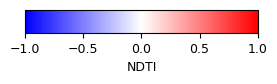

In [62]:
# Get dynamic visualization parameters for each masked NDTI image
ndti_vis_pre_monsoon = get_single_band_stretch_params(masked_ndti_pre_monsoon, "NDTI", study_area)
ndti_vis_monsoon = get_single_band_stretch_params(masked_ndti_monsoon, "NDTI", study_area)
ndti_vis_post_monsoon = get_single_band_stretch_params(masked_ndti_post_monsoon, "NDTI", study_area)
ndti_vis_winter = get_single_band_stretch_params(masked_ndti_winter, "NDTI", study_area)

# You can optionally add a palette to the generated vis parameters
# For example, using the existing ndti_vis palette:
ndti_vis_pre_monsoon['palette'] = ndti_vis['palette']
ndti_vis_monsoon['palette'] = ndti_vis['palette']
ndti_vis_post_monsoon['palette'] = ndti_vis['palette']
ndti_vis_winter['palette'] = ndti_vis['palette']


# Adding the masked NDTI layers to the map with dynamic visualization
Map.addLayer(masked_ndti_pre_monsoon, ndti_vis_pre_monsoon, "Masked NDTI Pre-Monsoon 2023 (Dynamic Vis)")
Map.addLayer(masked_ndti_monsoon, ndti_vis_monsoon, "Masked NDTI Monsoon 2023 (Dynamic Vis)")
Map.addLayer(masked_ndti_post_monsoon, ndti_vis_post_monsoon, "Masked NDTI Post-Monsoon 2023 (Dynamic Vis)")
Map.addLayer(masked_ndti_winter, ndti_vis_winter, "Masked NDTI Winter 2023-2024 (Dynamic Vis)")

# Add a legend for the NDTI layer
Map.add_colorbar(ndti_vis, label="NDTI", orientation="horizontal", position="bottomleft")


In [63]:
Map

Map(bottom=887723.0, center=[26.64766352124504, 88.4059669450329], controls=(WidgetControl(options=['position'…